import numpy as np
from functools import partial
import matplotlib.pyplot as plt 
import sympy as sp
from sympy.utilities.lambdify import lambdify

In [5]:
Y=np.load('tomatoes.npy') # Make sure you downloaded this file from Learn!
print('Length of data: ' + str(len(Y)))
print('Data:')
print(Y)

Length of data: 30
Data:
[13.27597167 15.08565281 13.41061844 11.5510474  10.63232069 13.76932811
 10.31644803 14.55388057 12.57937117 14.13647951 15.37354413  9.96525246
 12.66541964 11.33164599 12.14113179 11.57753389 15.86128067 10.23999543
 16.36971379 13.96021609 17.27321719 12.23476479 17.96792692 13.92888826
 10.64602864 16.45922776 15.56009798 13.02118014 16.50556431 14.08484862]


In [6]:
def U(q,y):
    m1,m2,m3 = q 
    
    # Your code here 
    prior = np.exp(-((13.5-m1)**2)/32)*np.exp(-((13.5-m2)**2)/32)*np.exp(-((13.5-m3)**2)/32)
    likelihood = sum(np.log(np.exp(-((y-m1)**2)/2)+np.exp(-((y-m2)**2)/2)+np.exp(-((y-m3)**2)/2)))
                        
    V = -np.log(prior)-likelihood
    return V
    


In [7]:
# To check:
U( [12,13,14], Y) - U( [11,12,13], Y)
# This should give 
# -23.67246392837439


-23.672463928374388

In [8]:
def force(q,y,y_batch):
    m1,m2,m3 = q
    
    N = len(y)
    n = len(y_batch)
    # constant number in the likelihood part of all derivatives
    denom = np.exp(-((y-m1)**2)/2)+np.exp(-((y-m2)**2)/2)+np.exp(-((y-m3)**2)/2)
    
    # should it be F = -dU_dq
    dU_dm1 = (13.5-m1)/16 + (N/n)*sum((y-m1)*np.exp(-((y-m1)**2)/2)/denom)
    dU_dm2 = (13.5-m2)/16 + (N/n)*sum((y-m2)*np.exp(-((y-m2)**2)/2)/denom)
    dU_dm3 = (13.5-m3)/16 + (N/n)*sum((y-m3)*np.exp(-((y-m3)**2)/2)/denom)
    
    dU_dq = np.array([dU_dm1,dU_dm2,dU_dm3])
    return dU_dq
    

In [9]:
force( [12,13,14], Y)
# This should give force components as 

# -5.879399468415861,
# 0.8083708852796383,
# 17.568681144234255

array([-5.87939947,  0.80837089, 17.56868114])

In [ ]:
def run_simulation_y( q0,p0, Nsteps, h, gamma, step_function, force_function, y):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 

    for n in range(Nsteps):
        q,p = step_function(q, p, h, gamma, force_function,y)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

**Try HMC in TensorFlow**
----
**The Rosenbrock Problem**

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [12]:
# reset to avoid restarting the kernel
tf.reset_default_graph()
# Target distribution is proportional to: `exp(-U(x))`.
def unnormalized_log_prob(x):
    # The rosenbrock function
    return -((1-x[0])**2 + 4*(2*x[1]-x[0]**2)**2)

# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=0.2,
    use_resource=True,  # For TFE compatibility.
    trainable=False)

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=np.array([1.,1.0/2],dtype='float32'),
    kernel=hmc)

# Initialize all constructed variables.
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    init_op.run()
    samples_, kernel_results_ = sess.run([samples, kernel_results])

print('meanx:{:.4f}  meany:{:.4f} stddev:{:.4f}  acceptance:{:.4f}'.format(
    samples_[:,0].mean(), samples_[:,1].mean(), samples_.std(), kernel_results_.is_accepted.mean()))


meanx:0.9403  meany:0.6412 stddev:0.6621  acceptance:0.5181


Stochastic Gradient Langevin Dynamics in TensorFlow
---


In [88]:
a = tf.constant([0.,4.])
g = tf.gradients(a + tf.exp(a), [a, a], stop_gradients=[a, a])

In [90]:
# print(a)
with tf.Session() as sess:
    c = sess.run(tf.Print(g,[g]))
    print(c)

[[ 2.      55.59815]
 [ 2.      55.59815]]


In [ ]:
# reset to avoid restarting the kernel
tf.reset_default_graph()

tfd = tfp.distributions
dtype = np.float32

with tf.Session(graph=tf.Graph()) as sess:
    # Set up random seed for the optimizer
    tf.set_random_seed(42)
    true_mean = dtype([11, 14, 16])
    true_cov = dtype([[1, 0.25, 0.25], [0.25, 1, 0.25], [0.25, 0.25, 1]])
    # Loss is defined through the Cholesky decomposition
    chol = tf.linalg.cholesky(true_cov)
    var_1 = tf.get_variable('var_1', initializer=[1., 1.])
    var_2 = tf.get_variable('var_2', initializer=[1.])

    var = tf.concat([var_1, var_2], axis=-1)
    # Partially defined loss function
    loss_part = tf.cholesky_solve(chol, tf.expand_dims(var, -1))
    # Loss function
    loss = 0.5 * tf.linalg.matvec(loss_part, var, transpose_a=True)

    # Set up the learning rate with a polynomial decay
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .3
    end_learning_rate = 1e-4
    decay_steps = 1e4
    learning_rate = tf.train.polynomial_decay(starter_learning_rate,global_step, decay_steps,end_learning_rate, power=1.)

    # Set up the optimizer
    optimizer_kernel = tfp.optimizer.StochasticGradientLangevinDynamics(
        learning_rate=learning_rate, preconditioner_decay_rate=0.99)

    optimizer = optimizer_kernel.minimize(loss)

    init = tf.global_variables_initializer()
    # Number of training steps
    training_steps = 5000
    # Record the steps as and treat them as samples
    samples = [np.zeros([training_steps, 2]), np.zeros([training_steps, 1])]
    sess.run(init)
    for step in range(training_steps):
        sess.run([optimizer, loss])
        sample = [sess.run(var_1), sess.run(var_2)]
        samples[0][step, :] = sample[0]
        samples[1][step, :] = sample[1]

    samples_ = np.concatenate(samples, axis=-1)
    sample_mean = np.mean(samples_, 0)
    print('sample mean', sample_mean)

In [25]:
dtype = np.float32
true_cov = dtype([[1, 0.25, 0.25], [0.25, 1, 0.25], [0.25, 0.25, 1]])
# Loss is defined through the Cholesky decomposition
chol = np.linalg.cholesky(true_cov)
print(chol)

[[1.         0.         0.        ]
 [0.25       0.96824586 0.        ]
 [0.25       0.19364917 0.9486833 ]]


In [93]:
print( [np.zeros([5, 2]), np.zeros([5, 1])])

[array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])]


Stochastic Gradient Langevin Dynamics
---

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
Y=np.load('tomatoes.npy') 
print('Length of data: ' + str(len(Y)))
print('Data:')
print(Y)

Length of data: 30
Data:
[13.27597167 15.08565281 13.41061844 11.5510474  10.63232069 13.76932811
 10.31644803 14.55388057 12.57937117 14.13647951 15.37354413  9.96525246
 12.66541964 11.33164599 12.14113179 11.57753389 15.86128067 10.23999543
 16.36971379 13.96021609 17.27321719 12.23476479 17.96792692 13.92888826
 10.64602864 16.45922776 15.56009798 13.02118014 16.50556431 14.08484862]


In [4]:
def U(q,y):
    m1,m2,m3 = q 
    
    # Your code here 
    prior = np.exp(-((13.5-m1)**2)/32)*np.exp(-((13.5-m2)**2)/32)*np.exp(-((13.5-m3)**2)/32)
    likelihood = sum(np.log(np.exp(-((y-m1)**2)/2)+np.exp(-((y-m2)**2)/2)+np.exp(-((y-m3)**2)/2)))
                        
    V = -np.log(prior)-likelihood
    return V
    

In [5]:
def force(q,y):
    m1,m2,m3 = q
    
    # constant number in the likelihood part of all derivatives
    denom = np.exp(-((y-m1)**2)/2)+np.exp(-((y-m2)**2)/2)+np.exp(-((y-m3)**2)/2)
    
    # should it be F = -dU_dq
    dU_dm1 = (13.5-m1)/16 + sum((y-m1)*np.exp(-((y-m1)**2)/2)/denom)
    dU_dm2 = (13.5-m2)/16 + sum((y-m2)*np.exp(-((y-m2)**2)/2)/denom)
    dU_dm3 = (13.5-m3)/16 + sum((y-m3)*np.exp(-((y-m3)**2)/2)/denom)
    
    dU_dq = np.array([dU_dm1,dU_dm2,dU_dm3])
    return dU_dq

In [6]:
def A_step( qp , h ):
    q,p = qp
    
    q = q + h*p
    p = p 
    
    return [q,p]

# New B step to include data y
def B_step_y( qp , h, force , y):
    q,p = qp
    
    # Your code here
    q = q
    p = p + h*force(q,y)

    return [q,p]

def O_step( qp , h,gamma ):
    q,p = qp
    
    # Your code here
    q = q
    R_t = np.random.randn(len(q))
    p = np.exp(-gamma*h)*p + np.sqrt(1-np.exp(-2*gamma*h))*R_t
    
    return [q,p]

# new OBABO to include data y
def ld_OBABO_y(q,p,h,gamma,force,y):
    # h=h/2
    qp = [q,p]
    
    O = O_step( qp, h/2, gamma )
    OB = B_step_y( O, h/2, force,y)
    OBA = A_step(OB, h)
    OBAB = B_step_y(OBA, h/2, force,y)
    OBABO = O_step( OBAB, h/2, gamma )
    
    q,p = OBABO
    q = q #+ np.random.normal(0,np.sqrt(h),3)
    return q , p 

# New run_simulation to accomodate the data y
def run_simulation_y( q0,p0, Nsteps, h, gamma, step_function, force_function, y,batch_size):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 

    for n in range(Nsteps):
        y_batch, y = get_minibatch(y,batch_size)
        q,p = step_function(q, p, h, gamma, force_function,y_batch)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

In [7]:
def get_minibatch(y,n):
    # x must be an array
    np.random.shuffle(y)
    batch = y[0:n-1]
    y = y
    return batch, y

In [8]:
# y_batch, y = get_minibatch(Y,5)
batch_size = 30
q0 = np.array([12,12,12])
p0 = np.random.randn(3)

Nsteps = 10000
h = 0.3
gamma = 1.0

# Run one long trajectory of Nsteps, using the OBABO scheme
q_traj, p_traj, t_traj = run_simulation_y(q0, p0, Nsteps , h, gamma, ld_OBABO_y, force, Y,batch_size)

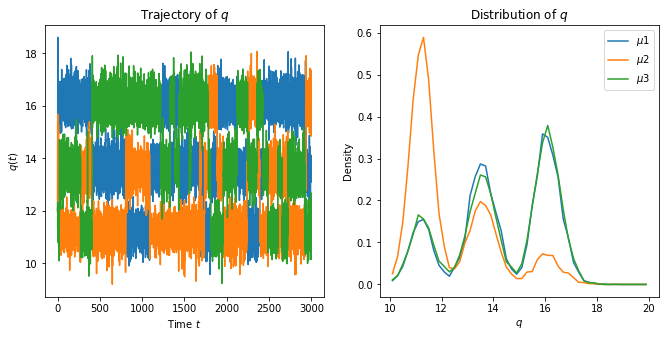

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (11,5))
plt.subplot(1,2,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

histogram_m1,bins_m1 = np.histogram(q_traj[:,0],bins=50,range=[10,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.subplot(1,2,2)

plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(q_traj[:,1],bins=50,range=[10,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(q_traj[:,2],bins=50,range=[10,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()
plt.show()

11.211578651012603 Standard Deviation: 0.46367500603172734
13.560557759918256 Standard Deviation: 0.5757814175034858
16.116078984019342 Standard Deviation: 0.49745254446964343


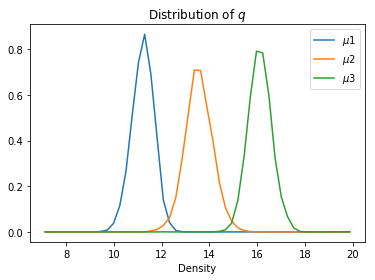

In [76]:
new_q_traj=np.sort(q_traj)

histogram_m1,bins_m1 = np.histogram(new_q_traj[:,0],bins=50,range=[7,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(new_q_traj[:,1],bins=50,range=[7,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(new_q_traj[:,2],bins=50,range=[7,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.xlabel('Density')
plt.legend()

print(np.mean(new_q_traj[:,0]), 'Standard Deviation:', np.std(new_q_traj[:,0]))
print(np.mean(new_q_traj[:,1]), 'Standard Deviation:', np.std(new_q_traj[:,1]))
print(np.mean(new_q_traj[:,2]), 'Standard Deviation:', np.std(new_q_traj[:,2]))

Simple Langevin Dynamics
---

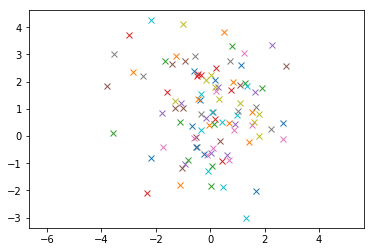

In [47]:
m = (0,1)
cov = [[2 , 0],[0 , 2]]
x1,y1 = np.random.multivariate_normal(m,cov, (100,1)).T
plt.plot(x1,y1,'x')
plt.axis('equal')
plt.show()

In [55]:
def Simple_LD(q,h,force,y):
    R = np.random.normal(0,np.sqrt(h),len(q))
    q = q + (h/2) * force(q,y) + R
    return q

In [56]:
def run_simulation_LD( q0, Nsteps, h, step_function, force_function, y):
    
    q_traj = [np.copy(q0)] 
    t_traj = [0]

    q = np.copy(q0) 
    t = 0 

    for n in range(Nsteps):
        q = step_function(q, h, force_function,y)
        t = t + h 

        q_traj += [q] 
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, t_traj

In [77]:
q0 = np.array([12,12,12])

Nsteps = 10000
h = 0.3

# Run one long trajectory of Nsteps, using the OBABO scheme
q_traj, t_traj = run_simulation_LD(q0, Nsteps , h, Simple_LD, force, Y)

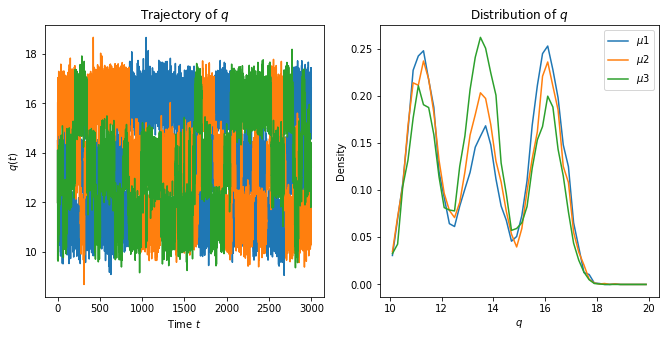

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize = (11,5))
plt.subplot(1,2,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

histogram_m1,bins_m1 = np.histogram(q_traj[:,0],bins=50,range=[10,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.subplot(1,2,2)

plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(q_traj[:,1],bins=50,range=[10,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(q_traj[:,2],bins=50,range=[10,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()
plt.show()

Mean 1: 11.226757381130305 Standard Deviation: 0.5830307680982019
Mean 2: 13.554203610084537 Standard Deviation: 0.6506649640061527
Mean 3: 16.109936825688855 Standard Deviation: 0.5971851243393177


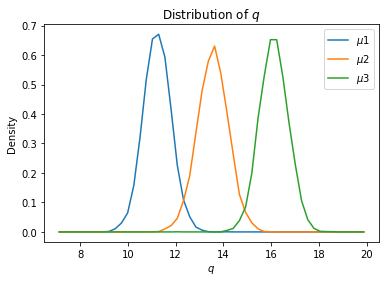

In [79]:
new_q_traj=np.sort(q_traj)

histogram_m1,bins_m1 = np.histogram(new_q_traj[:,0],bins=50,range=[7,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(new_q_traj[:,1],bins=50,range=[7,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(new_q_traj[:,2],bins=50,range=[7,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

print('Mean 1:',np.mean(new_q_traj[:,0]), 'Standard Deviation:', np.std(new_q_traj[:,0]))
print('Mean 2:',np.mean(new_q_traj[:,1]),'Standard Deviation:', np.std(new_q_traj[:,1]))
print('Mean 3:',np.mean(new_q_traj[:,2]),'Standard Deviation:', np.std(new_q_traj[:,2]))

Stochastic Gradient Langevin Dynamics
---

In [10]:
def SGLD(q,h,force,y,N):
    R = np.random.normal(0,np.sqrt(h),len(q))
    q = q + (h/2) * stochastic_force(q,y,N) + R
    return q

In [11]:
def stochastic_force(q,y,batch_scaling):
    m1,m2,m3 = q
    # constant number in the likelihood part of all derivatives
    denom = np.exp(-((y-m1)**2)/2)+np.exp(-((y-m2)**2)/2)+np.exp(-((y-m3)**2)/2)
    
    dU_dm1 = (13.5-m1)/16 + batch_scaling*sum((y-m1)*np.exp(-((y-m1)**2)/2)/denom)
    dU_dm2 = (13.5-m2)/16 + batch_scaling*sum((y-m2)*np.exp(-((y-m2)**2)/2)/denom)
    dU_dm3 = (13.5-m3)/16 + batch_scaling*sum((y-m3)*np.exp(-((y-m3)**2)/2)/denom)
    
    dU_dq = np.array([dU_dm1,dU_dm2,dU_dm3])
    return dU_dq

In [12]:
def run_simulation_SGLD( q0, Nsteps, h, step_function, force_function, y, batch_size):
    
    q_traj = [np.copy(q0)] 
    t_traj = [0]

    q = np.copy(q0) 
    t = 0 
    N = len(y)
    batch_scaling = N/batch_size
    
    for n in range(Nsteps):
        y_batch, y = get_minibatch(y,batch_size)
        q = step_function(q, h, force_function,y_batch,batch_scaling)
        t = t + h 

        q_traj += [q] 
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, t_traj

In [42]:
q0 = np.array([12,12,12])

Nsteps = 100000
h = 0.2

# Run one long trajectory of Nsteps, using the OBABO scheme
q_traj, t_traj = run_simulation_SGLD(q0, Nsteps , h, SGLD, stochastic_force, Y, 5)

In [34]:
y_batch, y = get_minibatch(Y,5)
print(len(t_traj))

100001


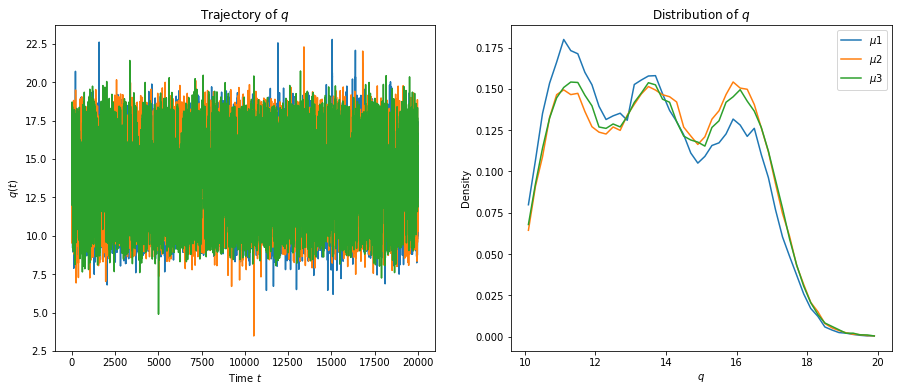

In [43]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

histogram_m1,bins_m1 = np.histogram(q_traj[:,0],bins=50,range=[10,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.subplot(1,2,2)

plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(q_traj[:,1],bins=50,range=[10,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(q_traj[:,2],bins=50,range=[10,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()
plt.show()

Mean 1: 11.21988535409352 Standard Deviation: 0.9258417535364485
Mean 2: 13.59616001142587 Standard Deviation: 0.9973855133150873
Mean 3: 16.165716782089785 Standard Deviation: 1.0318919862831726


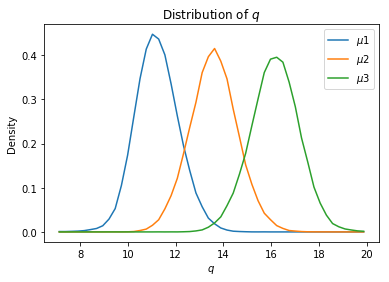

In [44]:
new_q_traj=np.sort(q_traj)

histogram_m1,bins_m1 = np.histogram(new_q_traj[:,0],bins=50,range=[7,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(new_q_traj[:,1],bins=50,range=[7,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(new_q_traj[:,2],bins=50,range=[7,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

print('Mean 1:',np.mean(new_q_traj[:,0]), 'Standard Deviation:', np.std(new_q_traj[:,0]))
print('Mean 2:',np.mean(new_q_traj[:,1]),'Standard Deviation:', np.std(new_q_traj[:,1]))
print('Mean 3:',np.mean(new_q_traj[:,2]),'Standard Deviation:', np.std(new_q_traj[:,2]))